<a href="https://colab.research.google.com/github/JulienGremillot/du_coup/blob/main/du_coup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

J'ai eu des problèmes de compatibilité niveau nombre de channels (mono/stereo), mais surtout au niveau du taux d'échantillonnage. J'arrivais à le corriger avec la librairie librosa, mais pas avec les objets Tensor... Bref, j'ai utilisé la ligne de commande suivante pour corriger mes samples avant les traitements : mkdir du_coup_2; for F in `ls du_coup/*`; do echo $F; F2=`echo $F | cut -d'/' -f2`; sox $F du_coup_2/$F2 remix 1 rate 16000; done

In [2]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 1s 0us/step


In [3]:
from google.colab import drive
import os
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [4]:
import shutil
src_du_coup = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/du_coup')
dst_du_coup = pathlib.Path(os.path.join(data_dir, 'du_coup'))
if not dst_du_coup.exists():
  print('Copie le répertoire', src_du_coup, 'vers', dst_du_coup)
  shutil.copytree(src_du_coup, dst_du_coup)
else:
  print('Le répertoire', dst_du_coup, 'existe déjà.')

Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/du_coup vers data/mini_speech_commands/du_coup


In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['left' 'right' 'up' 'no' 'down' 'du_coup' 'go' 'yes' 'stop']


In [6]:
from random import sample

def get_nb_files():
  nb_files = {}
  for command in commands:
    nb_files[command] = len(tf.io.gfile.listdir(str(data_dir/command)))
    print('-', command, ':', nb_files[command])
  return nb_files

print('Nombre de fichiers par label :')
nb_files = get_nb_files()

minimum = min(nb_files.values())
print('\nOn égalise le nombre de fichiers par le minimum (', minimum, ') :')
for command in commands:
  filenames = tf.io.gfile.listdir(os.path.join(data_dir, command))
  for file in sample(filenames, nb_files[command] - int(minimum)):
    os.remove(os.path.join(data_dir, command, file))

get_nb_files()

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('\nNombre total de fichiers :', num_samples)

Nombre de fichiers par label :
- left : 1000
- right : 1000
- up : 1000
- no : 1000
- down : 1000
- du_coup : 156
- go : 1000
- yes : 1000
- stop : 1000

On égalise le nombre de fichiers par le minimum ( 156 ) :
- left : 156
- right : 156
- up : 156
- no : 156
- down : 156
- du_coup : 156
- go : 156
- yes : 156
- stop : 156

Nombre total de fichiers : 1404


In [7]:
train_size = round(num_samples * 0.8)
val_size = round(num_samples * 0.1)
test_size = num_samples - train_size - val_size
train_files = filenames[:train_size]
val_files = filenames[train_size: train_size + val_size]
test_files = filenames[-test_size:]

print('Taille du training set :', len(train_files))
print('Taille du validation set :', len(val_files))
print('Taille du test set :', len(test_files))

Taille du training set : 1123
Taille du validation set : 140
Taille du test set : 141


In [8]:
test_file = tf.io.read_file(train_files[0])
print(train_files[0].numpy())
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

b'data/mini_speech_commands/go/2dce72b3_nohash_0.wav'


TensorShape([16000, 1])

In [9]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # la piste est mono, on supprime l'axe `channels`
  #if audio.shape[1] == 1:
  res = tf.squeeze(audio, axis=-1)
  # si la piste est stéréo, on ne conserve que la première piste
  #else:
  #  res = audio[:, 0]
  return res


def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]


def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

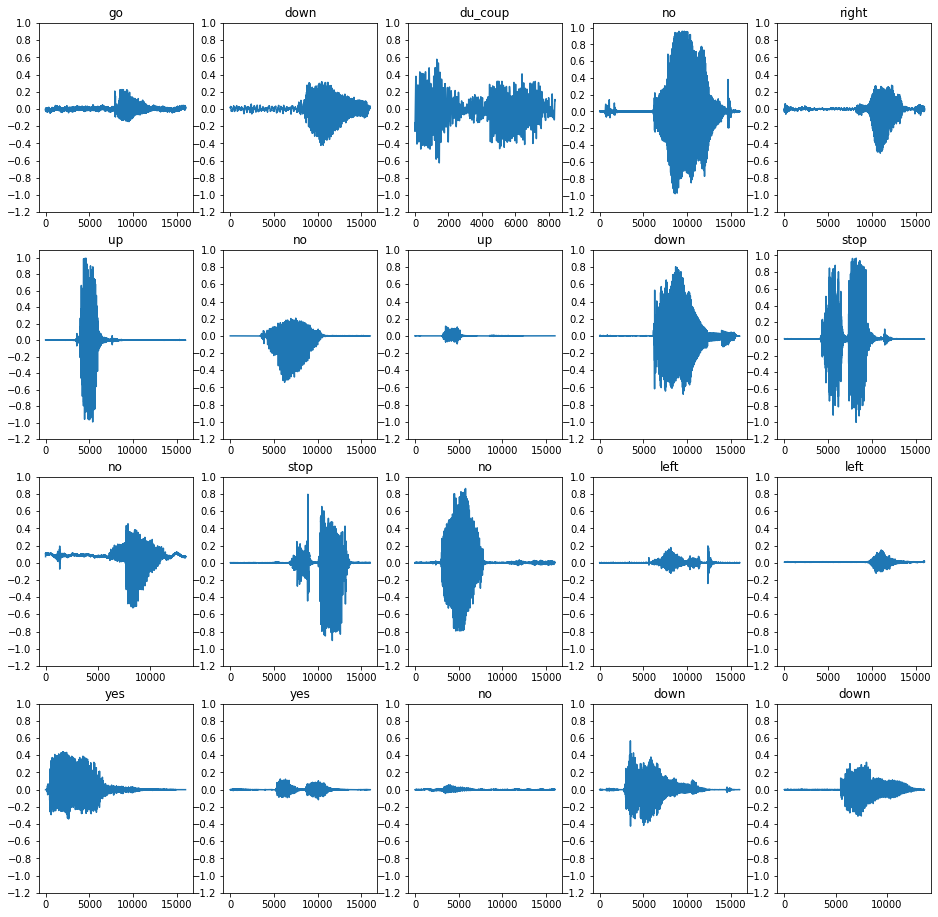

In [11]:
rows = 4
cols = 5
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [12]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(100):  
  label = label.numpy().decode('utf-8')
  if label == 'du_coup':
    spectrogram = get_spectrogram(waveform)
    break

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: du_coup
Waveform shape: (8364,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

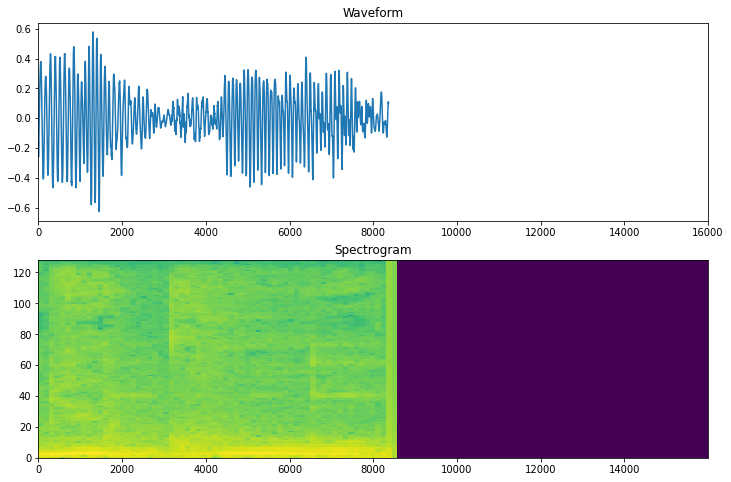

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [17]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

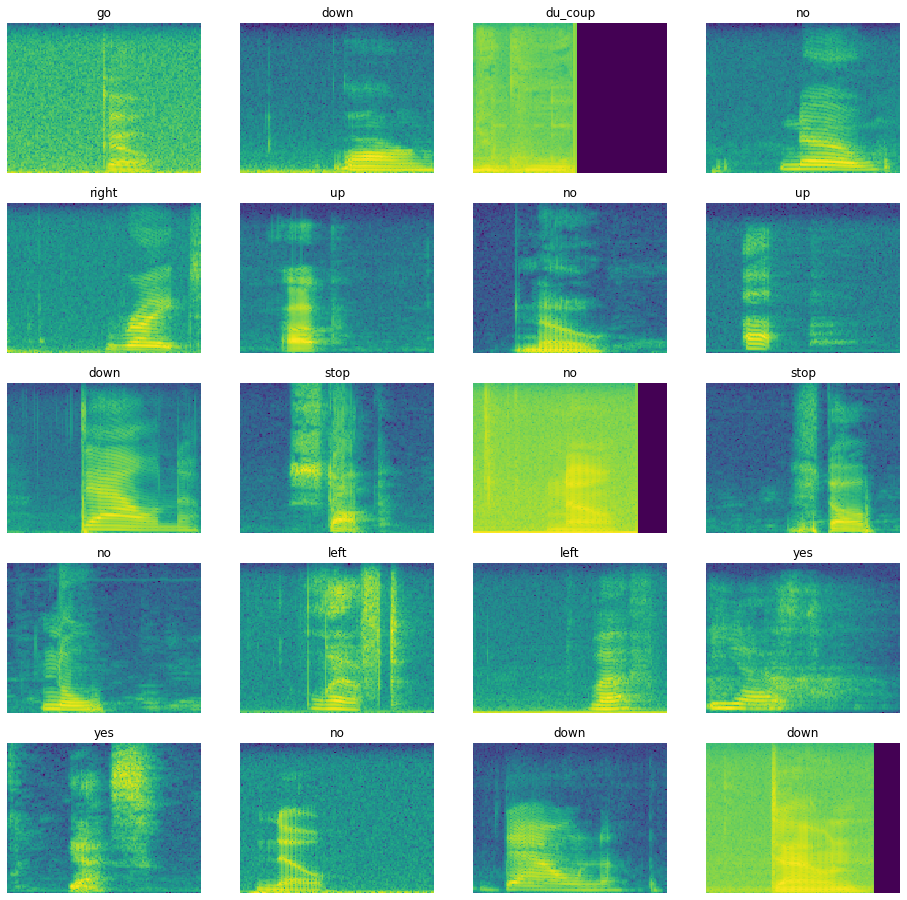

In [18]:
rows = 5
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/20
18/18 [==============================] - 7s 346ms/step - loss: 2.1279 - accuracy: 0.2280 - val_loss: 2.0214 - val_accuracy: 0.2071
Epoch 2/20
18/18 [==============================] - 3s 192ms/step - loss: 1.7878 - accuracy: 0.3713 - val_loss: 1.8382 - val_accuracy: 0.3643
Epoch 3/20
18/18 [==============================] - 3s 191ms/step - loss: 1.5594 - accuracy: 0.4639 - val_loss: 1.6456 - val_accuracy: 0.4214
Epoch 4/20
18/18 [==============================] - 3s 192ms/step - loss: 1.3962 - accuracy: 0.5085 - val_loss: 1.5365 - val_accuracy: 0.4714
Epoch 5/20
18/18 [==============================] - 3s 191ms/step - loss: 1.1971 - accuracy: 0.5637 - val_loss: 1.4471 - val_accuracy: 0.4929
Epoch 6/20
18/18 [==============================] - 3s 191ms/step - loss: 1.0469 - accuracy: 0.6385 - val_loss: 1.3366 - val_accuracy: 0.5214
Epoch 7/20
18/18 [==============================] - 3s 191ms/step - loss: 0.9332 - accuracy: 0.6598 - val_loss: 1.2730 - val_accuracy: 0.5857
Epoch 

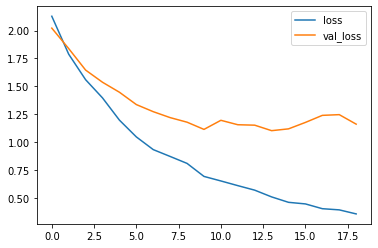

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 74%


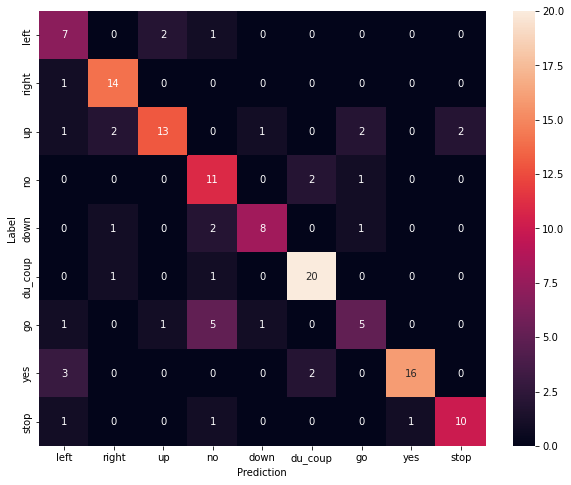

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

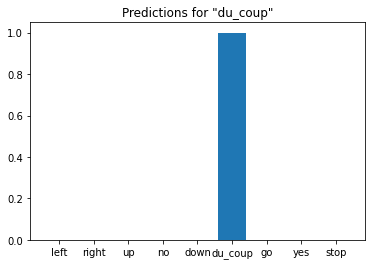

In [30]:
sample_file = data_dir/'du_coup/du_coup_15.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()